# Evaluación de nuestro RAG

In [34]:
from langchain_mistralai import ChatMistralAI
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_chroma import Chroma

from classes.chatbot import Chatbot

import pandas as pd
from tqdm import tqdm
import time
import warnings
from dotenv import load_dotenv
import os
import re

load_dotenv()
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
warnings.filterwarnings("ignore", category=FutureWarning)

El modelo que vamos a usar para las evaluaciones y nuestro RAG

In [35]:
llm = ChatMistralAI(
    model="mistral-small-latest", 
    mistral_api_key=MISTRAL_API_KEY,
    temperature=0, 
    random_seed=12345
)

search_type = "grafo" # ["similarity", "mmr", "tfidf", "bm25", "grafo"]
chatbot = Chatbot(chroma_directory="chroma", search_type=search_type)

Cargamos una muestra de nuestro dataset

In [36]:
df = pd.read_csv("eval/test - preguntas_mistral_plus.csv", on_bad_lines="skip")
df_shuffle = df.sample(frac=1, random_state=12345)
test_sample = df_shuffle.head(25)

In [37]:
test_sample

,Pregunta,Respuesta,Contexto,Recurso
209,¿Qué tipo de formación se financió con los Fon...,La formación financiada con los Fondos Next Ge...,ANEXO I Resoluciones del Servicio Público de E...,..\my_data\BOE-A-2024-26055.pdf
10,¿Hasta cuándo se extienden los plazos de prese...,Los plazos de presentación e ingreso de las de...,Artículo 7. Tramitación por el Consorcio de C...,..\my_data\BOE-A-2024-22928.pdf
300,¿Cuál es el número de identificación fiscal de...,S2800556I,BOLETÍN OFICIAL DEL ESTADO Núm. 37 Miércoles 1...,..\my_data\BOE-B-2025-4861.pdf
18,¿Cuál es el periodo en el que se aplica la exe...,La exención del 100 por ciento de la aportació...,periodos y porcentajes de jornada afectados po...,..\my_data\BOE-A-2024-22928.pdf
205,¿Quién fue nombrado Comisionado especial para ...,Don José María Ángel Batalla fue nombrado Comi...,"II. AUTORIDADES Y PERSONAL A. Nombramientos, s...",..\my_data\BOE-A-2024-25801.pdf
100,¿Estoy exento del pago de las cuotas del Impue...,"Sí, estás exento del pago de las cuotas del Im...",Cinco. Se da nueva redacción al apartado 1 del...,..\my_data\BOE-A-2024-23422.pdf
220,¿Puedo obtener financiación para renovar los a...,"Sí, podrás acogerte a la cobertura del aval pa...",2. Términos y condiciones aplicables al segund...,..\my_data\BOE-A-2024-26478.pdf
47,¿Qué medidas se han tomado para compensar la i...,Los operadores de comunicaciones electrónicas ...,temporal y por riesgo durante el embarazo y ri...,..\my_data\BOE-A-2024-23422.pdf
71,¿Qué documentos necesito para solicitar la dis...,Para solicitar la disposición anticipada de tu...,b) cuando sean trabajadores autónomos que se v...,..\my_data\BOE-A-2024-23422.pdf
20,¿Qué sucede con el tiempo de percepción de pre...,El tiempo en que se perciban prestaciones por ...,2. El tiempo en que se perciban prestaciones p...,..\my_data\BOE-A-2024-22928.pdf


## Configuración de los agentes críticos

- **Accuracy**: Grado de acierto de la respuesta final
- **Faithfulness**: Si la respuesta se basa exclusivamente en los documentos recuperados
- **Groundedness**: Si la pregunta puede ser respondida con el contexto aportado
- **Relevance**: Si los docs recuperados tienen que ver con la pregunta

In [38]:
accuracy_prompt = """
Tu tarea es evaluar la precisión de la respuesta generada por un sistema RAG. 
Debes comparar la respuesta generada con la respuesta esperada y determinar su precisión.
Tienes que dar tu respuesta en una escala del 0 al 5, donde 0 significa que la respuesta es totalmente incorrecta y 5 significa que es completamente correcta y precisa.

Provee tu respuesta como sigue:

Respuesta:::
Rating: (tu rating, como número del 0 al 5)

Aqui tienes la respuesta esperada y la respuesta generada por el sistema RAG.

Respuesta esperada: {respuesta_esperada}\n
Respuesta generada: {respuesta_generada}\n
Respuesta:::
"""

faithfulness_prompt = """
Tu tarea es evaluar si la respuesta generada se basa únicamente en la información proporcionada en los documentos. 
No debe contener invenciones o afirmaciones que no estén respaldadas por los textos.
Tienes que dar tu respuesta en una escala del 0 al 5, donde 0 significa que la respuesta contiene información inventada o irrelevante y 5 significa que es totalmente fiel al contenido de los documentos.

Provee tu respuesta como sigue:

Respuesta:::
Rating: (tu rating, como número del 0 al 5)

Aqui tienes los documentos recuperados y la respuesta generada por el sistema RAG.

Documentos recuperados: {documentos}\n
Respuesta generada: {respuesta}\n
Respuesta:::
"""

groundedness_prompt = """
Tu tarea es evaluar si la respuesta generada está bien fundamentada en el contenido de los documentos proporcionados. 
La respuesta debe usar la evidencia relevante de forma clara y apropiada.
Tienes que dar tu respuesta en una escala del 0 al 5, donde 0 significa que no utiliza los documentos o lo hace de forma incorrecta y 5 significa que usa la información de manera excelente y precisa.

Provee tu respuesta como sigue:

Respuesta:::
Rating: (tu rating, como número del 0 al 5)

Aqui tienes los documentos recuperados y la respuesta generada por el sistema RAG.

Documentos recuperados: {documentos}\n
Respuesta generada: {respuesta}\n
Respuesta:::
"""

relevance_prompt = """
Tu tarea es evaluat qué tan relevantes son los documentos recuperados con respecto a la pregunta formulada.
Considera si aportan información útil para construir una respuesta adecuada.
Tienes que dar tu respuesta en una escala del 0 al 5, donde 0 significa que los documentos son irrelevantes y 5 significa que son totalmente relevantes y adecuados.

Provee tu respuesta como sigue:

Aquí tienes la pregunta y los documentos recuperados.

Respuesta:::
Rating: (tu rating, como número del 0 al 5)

Pregunta: {pregunta}\n
Documentos recuperados: {documentos}\n
Respuesta:::
"""

In [39]:
def get_response(question: str, chatbot: Chatbot):
    results = chatbot.get_retriever().batch([question])
    context = "\n\n---\n\n".join([doc.page_content for doc in results[0]]) # contexto
    
    response = chatbot.answer_query2(question, context)

    return response, context

In [40]:
columns = [
    "pregunta", "respuesta esperada", "respuesta generada", 
    "accuracy", "faithfulness", 
    "groundedness", "relevance"
]

eval_rag = []

sleep = 2

for index, row in tqdm(test_sample.iterrows(), desc="Evaluando el RAG", total=len(test_sample), unit="preguntas"):
    pregunta = row["Pregunta"]
    respuesta = row["Respuesta"]
    contexto = row["Contexto"]       

    time.sleep(sleep) # Espera para evitar sobrecargar el servidor

    respuesta_generada, docs_recuperados = get_response(pregunta, chatbot)  

    evaluations = {
        "accuracy": accuracy_prompt.format(respuesta_esperada=respuesta, respuesta_generada=respuesta_generada),
        "faithfulness": faithfulness_prompt.format(documentos=docs_recuperados, respuesta=respuesta_generada),
        "groundedness": groundedness_prompt.format(documentos=docs_recuperados, respuesta=respuesta_generada),
        "relevance": relevance_prompt.format(pregunta=pregunta, documentos=docs_recuperados)
    }    

    try:

        eval_row = {
            "pregunta": pregunta,
            "respuesta esperada": respuesta,
            "respuesta generada": respuesta_generada            
        }

        for criterion, evaluation in evaluations.items():         

            time.sleep(sleep) # Espera para evitar sobrecargar el servidor

            chain = llm | StrOutputParser()
            response = chain.invoke(evaluation)
            match = re.search(r'Rating:\s*(\d+)', response)
            score = int(match.group(1))

            eval_row[criterion] = score


        eval_rag.append(eval_row)
            
    except Exception as e:
        continue

Evaluando el RAG: 100%|██████████| 25/25 [08:56<00:00, 21.47s/preguntas]


In [41]:
eval_rag_df = pd.DataFrame(eval_rag, columns=columns)
eval_rag_df

,pregunta,respuesta esperada,respuesta generada,accuracy,faithfulness,groundedness,relevance
0,¿Qué tipo de formación se financió con los Fon...,La formación financiada con los Fondos Next Ge...,La formación financiada con los Fondos Next Ge...,3,5,4,4
1,¿Hasta cuándo se extienden los plazos de prese...,Los plazos de presentación e ingreso de las de...,Los plazos de presentación e ingreso de declar...,3,5,5,3
2,¿Cuál es el número de identificación fiscal de...,S2800556I,No lo sé.,0,5,0,1
3,¿Quién fue nombrado Comisionado especial para ...,Don José María Ángel Batalla fue nombrado Comi...,No lo sé.,0,0,0,1
4,¿Estoy exento del pago de las cuotas del Impue...,"Sí, estás exento del pago de las cuotas del Im...","Sí, estás exento del pago de las cuotas del Im...",4,5,4,2
5,¿Puedo obtener financiación para renovar los a...,"Sí, podrás acogerte a la cobertura del aval pa...","Sí, puedes obtener financiación para renovar l...",3,5,5,5
6,¿Qué medidas se han tomado para compensar la i...,Los operadores de comunicaciones electrónicas ...,Para compensar la interrupción de los servicio...,4,5,5,4
7,¿Qué documentos necesito para solicitar la dis...,Para solicitar la disposición anticipada de tu...,No lo sé.,0,1,0,1
8,¿Qué sucede con el tiempo de percepción de pre...,El tiempo en que se perciban prestaciones por ...,El tiempo de percepción de prestaciones por ce...,1,5,4,3
9,¿Hasta cuándo puedo solicitar la prestación po...,La prestación por cese de actividad podrá exte...,No lo sé.,0,0,0,3


In [42]:
scores_columns = ["accuracy", "faithfulness", "groundedness", "relevance"]
scores_df = round(eval_rag_df[scores_columns].mean(),2)
scores_df = scores_df.to_frame().transpose()
scores_df

,accuracy,faithfulness,groundedness,relevance
0,2.57,4.0,3.39,2.91


In [43]:
%matplotlib inline

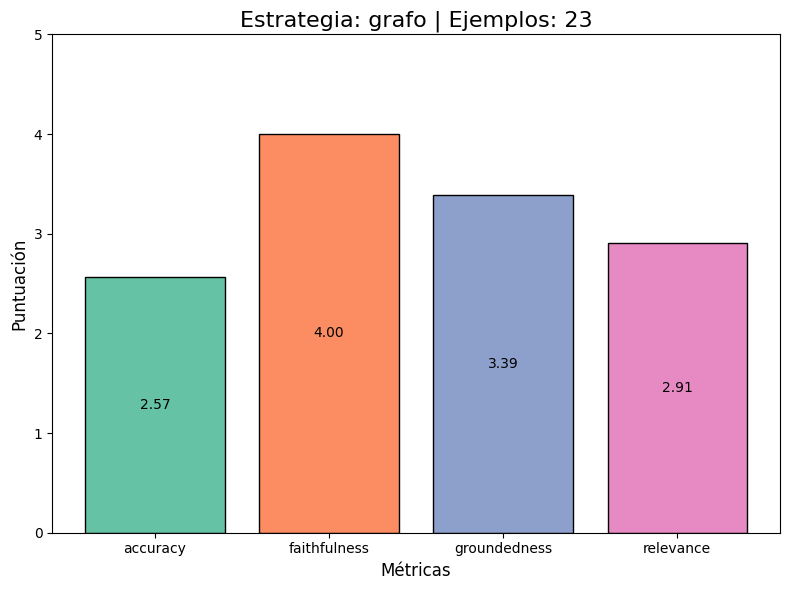

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transponer el DataFrame para facilitar el plot
data = scores_df.transpose()
data.columns = ["Puntuación"]

# Colores distintos para cada barra
colors = sns.color_palette("Set2", n_colors=len(data))

# Crear la figura
plt.figure(figsize=(8, 6))

# Crear el gráfico de barras
bars = plt.bar(data.index, data["Puntuación"], color=colors, edgecolor='black')

# Añadir etiquetas centradas dentro de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{height:.2f}",
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

num_rows = len(eval_rag_df)

# Personalizar la gráfica
plt.title(f"Estrategia: {search_type} | Ejemplos: {num_rows}", fontsize=16)
plt.xlabel("Métricas", fontsize=12)
plt.ylabel("Puntuación", fontsize=12)
plt.ylim(0, 5)
plt.xticks(rotation=0)  
plt.tight_layout()

# Guardar y mostrar la gráfica
plt.savefig(f"images/eval_{search_type}.png", dpi=300, bbox_inches="tight")
plt.show()

